In [1]:
import logging
import json
import random
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import time
import numpy as np
import sys
from models.baseline_snli import encoder
from models.baseline_snli import LSTMTagger
import argparse
from models.snli_data import snli_data
from models.snli_data import w2v
from torch import autograd
from IPython.display import Markdown, display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def get_errors(dev_lbl_batch,pred):
    error_list=[]
    for i,v in enumerate(dev_lbl_batch.data.numpy()):
        if v != pred[i]:
            error_list.append((i,'T: '+labels_mapping[v]+', O: '+labels_mapping[pred[i]]))
        else:
            error_list.append((i,'T,O:'+labels_mapping[v]))
    return error_list


def update_error_analysis_dict(actual_labels, pred_labels):
    for i in range (len(actual_labels)):
        error_analysis[labels_mapping[actual_labels[i]]][labels_mapping[pred_labels[i]]] += 1

def print_sentence(batch,idx,return_result=True):
    premise = []
    hypothesis = []
    s = dev_batches[batch]
    for pword in s[0][idx]:
        premise.append(idx_to_word[pword])
    for hword in s[1][idx]:
        hypothesis.append(idx_to_word[hword])
    if return_result is True:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)+'\n'+outcomes[batch][1][idx][1]
    else:
        return 'Premise: '+' '.join(premise)+'\nHypothesis: '+' '.join(hypothesis)

def heatmap(batch,idx):
    batch_num = batch
    item_in_batch = idx
    hypothesis_words = []
    premise_words = []
    for i in dev_batches[batch_num][0][item_in_batch]:
        premise_words.append(idx_to_word[i])
    for i in dev_batches[batch_num][1][item_in_batch]:
        hypothesis_words.append(idx_to_word[i])
    df = pd.DataFrame(alphas[batch_num][:,item_in_batch].data.numpy().T, columns=hypothesis_words, index=premise_words)
    sns.heatmap(df, cmap="YlGnBu", annot=True)
    print(print_sentence(batch_num,item_in_batch))
    plt.show()

    
def printmd(string):
    display(Markdown(string))


'''
Error Analysis
'''
from collections import defaultdict

labels_mapping = {1:'neutral', 0:'entailment', 2:'contradiction'}
error_analysis = defaultdict(dict)
labels = ['neutral', 'entailment', 'contradiction']

for i in labels_mapping.values():
    for j in labels:
        error_analysis[i][j] = 0

# Load Files

In [4]:
mypath='/Users/danielamaranto/Desktop/nlppaper/process/'

In [5]:
#Load validation set
w2v_file = mypath+"snli_preprocess/glove.hdf5"

word_vecs = w2v(w2v_file).word_vecs 
dev_file = mypath+"snli_preprocess/val.hdf5"

dev_data = snli_data(dev_file, -1)
dev_batches = dev_data.batches

In [6]:
#Load index to word dictionary
word_dict_path = mypath+'snli_preprocess/word.dict'
idx_to_word = {}
with open(word_dict_path,'r') as inf:
    for line in inf:
        line = line.split()
        idx_to_word[int(line[1])] = line[0]
'''change to 0 indexing'''
idx_to_word = {k-1:v for k,v in idx_to_word.items()}

In [7]:
#Load Model
encode_model_fp = '../03_epoch-54_dev-acc-0.768_input-encoder.pt'
atten_model_fp = '../03_epoch-54_dev-acc-0.768_lstm.pt'
embedding_size = 300
hidden_size = 107
train_lbl_size = 3
para_init = 0.01

#init
input_encoder = encoder(word_vecs.size(0), embedding_size, hidden_size, para_init)
inter_atten = LSTMTagger(hidden_size, train_lbl_size)

#load state (map_location converts model from gpu to cpu)
input_encoder.load_state_dict(torch.load(encode_model_fp, map_location=lambda storage, loc: storage))
inter_atten.load_state_dict(torch.load(atten_model_fp, map_location=lambda storage, loc: storage))

# Eval Dev Set

In [8]:
'''
Evaluate model on the dev set.
This may take a few minutes to run.
'''

input_encoder.eval()
inter_atten.eval()
correct = 0.
total = 0.
predicted_lbls = []
alphas = []
outcomes = []

for i in range(len(dev_batches)):
    dev_src_batch, dev_tgt_batch, dev_lbl_batch = dev_batches[i]
    dev_src_batch = Variable(dev_src_batch)
    dev_tgt_batch = Variable(dev_tgt_batch)
    dev_lbl_batch = Variable(dev_lbl_batch)

    dev_src_linear, dev_tgt_linear=input_encoder(
        dev_src_batch, dev_tgt_batch)
    log_prob, alpha=inter_atten(dev_src_linear, dev_tgt_linear, return_attn=True)

    _, predict=log_prob.data.max(dim=1)
    total += dev_lbl_batch.data.size()[0]
    correct += torch.sum(predict == dev_lbl_batch.data)
    update_error_analysis_dict(dev_lbl_batch.data, predict)
    predicted_lbls.append(predict)
    alphas.append(alpha)
    results = get_errors(dev_lbl_batch,predict)
    outcomes.append((i,results))

In [9]:
'''Collect Prediciton types into dictionaries'''
names = ['T,O:entailment',
         'T,O:neutral',
         'T,O:contradiction',
         'T: entailment, O: contradiction',
         'T: entailment, O: neutral',
         'T: neutral, O: entailment',
         'T: neutral, O: contradiction',
         'T: contradiction, O: entailment',
         'T: contradiction, O: neutral']

correct_idxs = dict.fromkeys(names[:3])
error_idxs = dict.fromkeys(names[3:])

for i in range(len(outcomes[:-1])):
    for j in range(len(outcomes[i][1])):
        if outcomes[i][1][j][1] in names[3:]:
            try:
                error_idxs[outcomes[i][1][j][1]].append((i,j))
            except:
                error_idxs[outcomes[i][1][j][1]]=[(i,j)]
        if outcomes[i][1][j][1] in names[:3]:
            try:
                correct_idxs[outcomes[i][1][j][1]].append((i,j))
            except:
                correct_idxs[outcomes[i][1][j][1]]=[(i,j)]

# Correct examples

# **T,O:entailment**

Premise: <s> trucks racing
Hypothesis: <s> there are vehicles
T,O:entailment


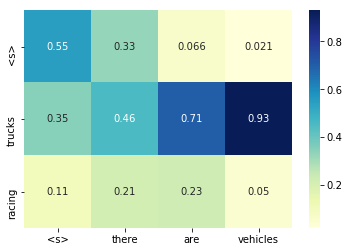

Premise: <s> javelin competition
Hypothesis: <s> there is a competition
T,O:entailment


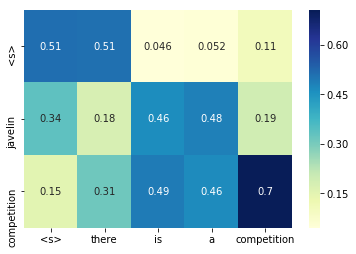

# **T,O:neutral**

Premise: <s> javelin competition
Hypothesis: <s> the woman one the javelin competition
T,O:neutral


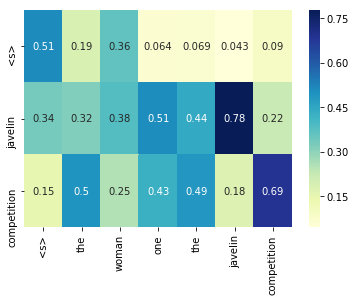

Premise: <s> two dogs play
Hypothesis: <s> the dogs are friends
T,O:neutral


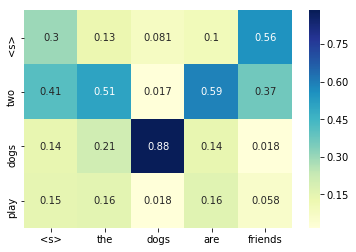

# **T,O:contradiction**

Premise: <s> men playing football
Hypothesis: <s> some men sleep
T,O:contradiction


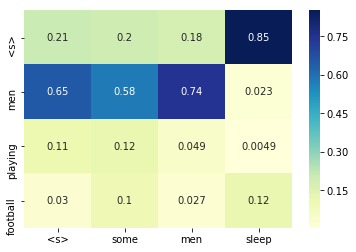

Premise: <s> two dogs play
Hypothesis: <s> two cats are playing
T,O:contradiction


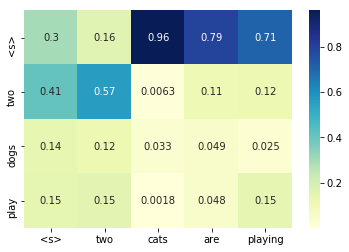

In [11]:
'''Print indexes of different error types'''
for i in correct_idxs.keys():
    printmd('# **'+i+'**')
    for j in range(2): # For each type of prediction, prints the first two examples
        entry = correct_idxs[i][j]
        heatmap(entry[0],entry[1])

# Incorrect examples

# **T: entailment, O: contradiction**

Premise: <s> a hockey fight
Hypothesis: <s> fighting on the ice
T: entailment, O: contradiction


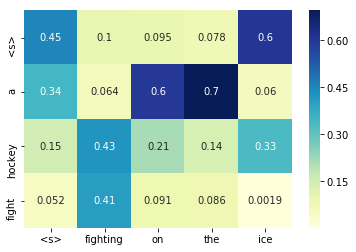

Premise: <s> two girls play with origami
Hypothesis: <s> the girls hold paper
T: entailment, O: contradiction


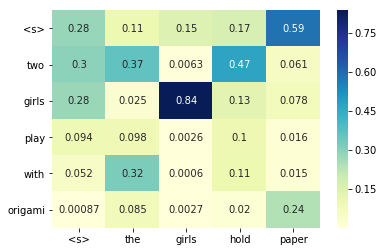

# **T: entailment, O: neutral**

Premise: <s> trucks racing
Hypothesis: <s> four trucks are racing against each other in the relay
T: entailment, O: neutral


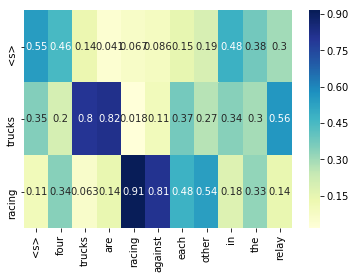

Premise: <s> a man snowboards
Hypothesis: <s> a man is standing on a snowboard
T: entailment, O: neutral


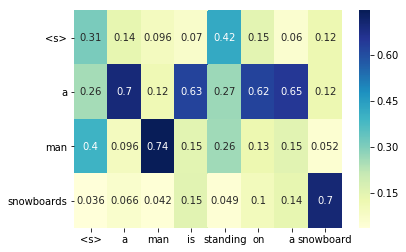

# **T: neutral, O: entailment**

Premise: <s> a skateboarder <oov34>
Hypothesis: <s> someone is skateboarding outside
T: neutral, O: entailment


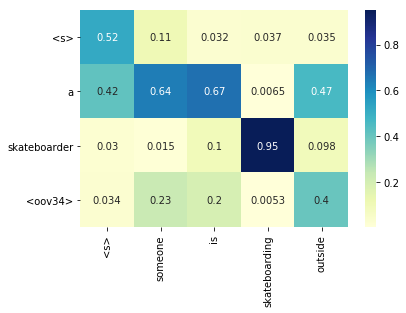

Premise: <s> men playing football
Hypothesis: <s> some men are playing a game outside
T: neutral, O: entailment


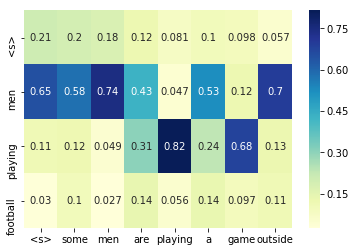

# **T: neutral, O: contradiction**

Premise: <s> javelin competition
Hypothesis: <s> the javelin competition was cancelled due to rain
T: neutral, O: contradiction


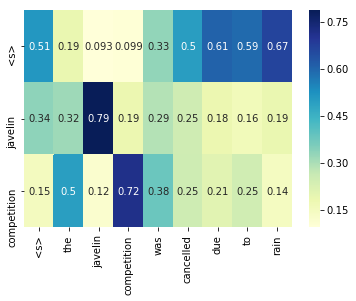

Premise: <s> a motorcycle races
Hypothesis: <s> a bike is racing a cheetah
T: neutral, O: contradiction


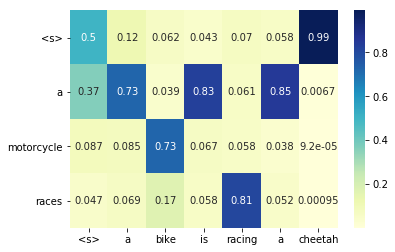

# **T: contradiction, O: entailment**

Premise: <s> stretching before roller derby
Hypothesis: <s> stretching before a <oov95>
T: contradiction, O: entailment


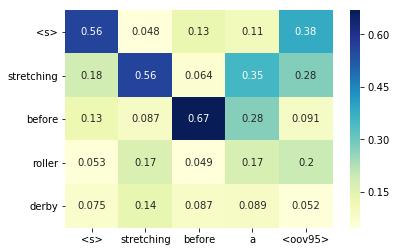

Premise: <s> a guitarist performs on stage
Hypothesis: <s> the drummer performs
T: contradiction, O: entailment


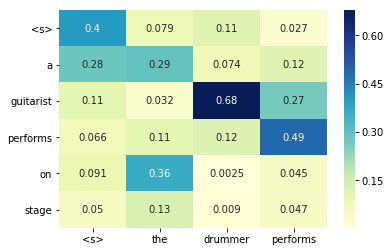

# **T: contradiction, O: neutral**

Premise: <s> trucks racing
Hypothesis: <s> the trucks are stationary in the parking lot
T: contradiction, O: neutral


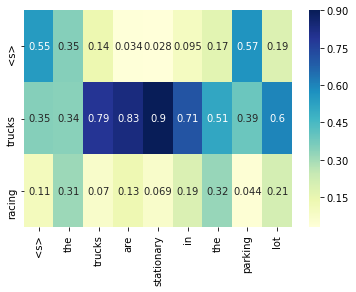

Premise: <s> two men play basketball
Hypothesis: <s> two men are playing dodge ball
T: contradiction, O: neutral


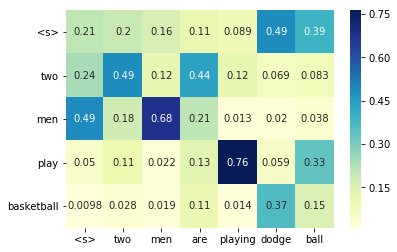

In [12]:
'''Print indexes of different error types'''
for i in error_idxs.keys():
    printmd('# **'+i+'**')
    for j in range(2): # For each type of prediction, prints the first two examples
        entry = error_idxs[i][j]
        heatmap(entry[0],entry[1])